# ATSR501 Fall 2025 Final Project
## Fornax Chemical Evolution Trend
Minjih Kim

Date: 15/12/2025

This code was developed with the help of ChatGPT-5.

In [1]:
# Import standard Python packages
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from pathlib import Path 
import sys

# root paths help resolve data assets and allow local imports
repo_root = Path('.').resolve()  # repository base used to resolve data files
package_root = repo_root.parent  # NuPyCEE package resides one directory above
if str(package_root) not in sys.path:  # keep sys.path modification idempotent
    sys.path.insert(0, str(package_root))  # register NuPyCEE package for imports

# One-zone galactic chemical evolution code
import NuPyCEE.omega as omega

# Stellar abundances plotting code
import NuPyCEE.stellab as stellab

# Matplotlib option
%matplotlib inline

## Fornax Stellar Abundances

Load Fornax stellar abundances from Reichert et al. (2020), downloaded from https://cdsarc.u-strasbg.fr/viz-bin/cat/J/A+A/641/A127 
- not available in stellab

In [2]:
# observational Eu catalog for Fornax (Reichert et al. 2020)
reichert_csv = repo_root / "observations" / "reichert2020_for.csv"  # processed observational dataset

if not reichert_csv.exists():  # guard against missing input file
    raise FileNotFoundError(
        "Missing observations/reichert2020_for.csv. ",
        "Run observations/generate_reichert2020_for_csv.py to build it.",
    )

obs_df = pd.read_csv(reichert_csv)  # load observational measurements into DataFrame
obs_df = obs_df.rename(columns={"ID": "star"})  # adopt clearer star identifier label
obs_df = obs_df.dropna(subset=["[Fe/H]", "[Eu/Fe]"])  # keep entries with complete abundance info
# ensure only stars with both Fe and Eu remain
obs_df = obs_df.sort_values("[Fe/H]").reset_index(drop=True)  # order by metallicity for plotting

print(f"Loaded {len(obs_df)} Reichert et al. (2020) Fornax stars with Eu measurements")

Loaded 108 Reichert et al. (2020) Fornax stars with Eu measurements


Load Fornax stellar abundances from Letarte et al. (2010) and Lemasle et al. (2014), directly from the txt files, for custom plotting.

In [3]:
from stellab_utils import parse_stellab_file, ensure_abundance_columns

p1 = 'stellab_data/fornax_data/Letarte_et_al_2010_stellab.txt'
p2 = 'stellab_data/fornax_data/Lemasle_et_al_2014_stellab.txt'

df1 = parse_stellab_file(p1)
df2 = parse_stellab_file(p2)

# Ensure required [X/Fe] columns exist so plotting won't error
# Not included: "Zn" (only 3 stars), "Sr" (0 stars) in Reichert et al. (2020)
elements = ["Mg", "Sc", "Ti", "Cr", "Mn", "Ni", "Y", "Ba", "Eu"] 
ensure_abundance_columns(df1, elements)
ensure_abundance_columns(df2, elements)

# Optional: inspect the canonical columns
print('df1 columns ->', list(df1.columns))
print('df2 columns ->', list(df2.columns))

df1 columns -> ['[Na/Fe]', 'err', '[Mg/Fe]', 'err_1', '[Si/Fe]', 'err_2', '[Ca/Fe]', 'err_3', '[Ti/Fe]', 'err_4', '[Ti2/Fe]', 'err_5', '[Cr/Fe]', 'err_6', '[Fe/H]', 'err_7', '[Fe2/H]', 'err_8', '[Ni/Fe]', 'err_9', '[Y/Fe]', 'err_10', '[Ba/Fe]', 'err_11', '[La/Fe]', 'err_12', '[Nd/Fe]', 'err_13', '[Eu/Fe]', 'err_14', '[Fe2/Fe]', '[Sc/Fe]', '[Mn/Fe]']
df2 columns -> ['[Fe/H]', 'err', '[FeII/H]', 'err_1', '[Na/H]', 'err_2', '[Mg/H]', 'err_3', '[Si/H]', 'err_4', '[Ca/H]', 'err_5', '[Sc/H]', 'err_6', '[Ti/H]', 'err_7', '[TiII/H]', 'err_8', '[Cr/H]', 'err_9', '[Ni/H]', 'err_10', '[Y/H]', 'err_11', '[Ba/H]', 'err_12', '[La/H]', 'err_13', '[Nd/H]', 'err_14', '[Eu/H]', 'err_15', '[FeII/Fe]', '[Na/Fe]', '[Mg/Fe]', '[Si/Fe]', '[Ca/Fe]', '[Sc/Fe]', '[Ti/Fe]', '[TiII/Fe]', '[Cr/Fe]', '[Ni/Fe]', '[Y/Fe]', '[Ba/Fe]', '[La/Fe]', '[Nd/Fe]', '[Eu/Fe]', '[Mn/Fe]']


/home/minjih/NuPyCEE/stellab_utils.py:86: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True, comment="#", header=0, engine="python")
/home/minjih/NuPyCEE/stellab_utils.py:86: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=True, comment="#", header=0, engine="python")


Load NSM yields from Rosswog et al. (2014), to manually inject NSM yields at delayed times.

In [19]:
# Parse Rosswog et al. (2014) r-process yields
nsm_yield_file = repo_root / "yield_tables" / "r_process_rosswog_2014.txt"

# Parse the yield file to extract isotope names and mass fractions
nsm_isotope_names = []
nsm_mass_fractions = []

with open(nsm_yield_file, 'r') as f:
    for line in f:
        line = line.strip()
        # Skip comment lines (starting with 'H') and empty lines
        if not line or line.startswith('H '):
            continue
        
        # Parse lines with format: &Isotope-Name &mass_fraction
        if line.startswith('&'):
            parts = line.split()
            if len(parts) >= 2 and parts[0] != "&Isotopes":
                isotope_name = parts[0][1:]  # Remove leading '&'
                mass_fraction = float(parts[1][1:])  # Remove leading '&' and convert
                nsm_isotope_names.append(isotope_name)
                nsm_mass_fractions.append(mass_fraction)

# Total r-process ejecta mass per NSM event
nsm_ejecta_mass = 0.01  # Msun

# Convert mass fractions to masses in Msun
nsm_masses = [mf * nsm_ejecta_mass for mf in nsm_mass_fractions]

# Store as dictionary
nsm_data = dict(zip(nsm_isotope_names, nsm_masses))

print(f"Loaded {len(nsm_data)} isotopes from Rosswog et al. (2014)")
print(f"Total r-process ejecta mass per NSM: {nsm_ejecta_mass} Msun")
print(f"Sum of mass fractions: {sum(nsm_mass_fractions):.6f}")

Loaded 246 isotopes from Rosswog et al. (2014)
Total r-process ejecta mass per NSM: 0.01 Msun
Sum of mass fractions: 1.000000


## Plotting functions
using color-blind friendly palette

In [4]:
def plot_grid(models, title=None, save_fig = True):
    # Okabe–Ito color-blind friendly palette
    palette = {
        'black': '#000000',
        'orange': '#E69F00',
        'sky': '#56B4E9',
        'green': '#009E73',
        'yellow': '#F0E442',
        'blue': '#0072B2',
        'vermillion': '#D55E00',
        'purple': '#CC79A7',
    }
    # Observational dataset colors
    obs_letarte = palette['blue']
    obs_lemasle = palette['sky']
    obs_reichert = palette['black']
    # Model line colors (3 models expected)
    model_colors = [palette['orange'], palette['green'], palette['purple']]

    ncols = 3
    nplots = len(elements)
    nrows = math.ceil(nplots / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows), sharex=True)
    axes = axes.flatten()

    # Optional per-element y-limits (tune as you like)
    ylim_dict = {
        'Eu': (-2.0, 2.0),
        'Mg': (-1.0, 1.0),
        'Ba': (-1.5, 1.5),
        'Sc': (-1.5, 1.0),
        'Ti': (-1.5, 1.0),
        'Cr': (-1.5, 1.0),
        'Mn': (-1.5, 0.5),
        'Ni': (-1, 1.5),
        'Y': (-1.5, 1.0),
    }

    # Plot each element into its subplot but do NOT draw per-axis legends
    for i, elem in enumerate(elements):
        ax = axes[i]
        plt.sca(ax)  # make this subplot the current axes so the called function plots into it

        yaxis = f'[{elem}/Fe]'

        # Plot stellar abundances derived from observations (labels retained for global legend)
        matplotlib.rcParams.update({'font.size': 16.0})
        ax.scatter(df1['[Fe/H]'], df1[yaxis], s=35, label='Letarte et al. (2010)', color=obs_letarte)
        ax.scatter(df2['[Fe/H]'], df2[yaxis], s=35, label='Lemasle et al. (2014)', color=obs_lemasle)
        ax.scatter(obs_df['[Fe/H]'], obs_df[yaxis], s=35, alpha=0.55, label='Reichert et al. (2020)', color=obs_reichert)

        for info, color in zip(models, model_colors):
            model, label = info
            # Overplot the predictions on top of observations
            xy = model.plot_spectro(xaxis='[Fe/H]', yaxis=yaxis, return_x_y=True)
            ax.plot(xy[0], xy[1], color=color, linewidth=1.5, label=label)
        # Do not call ax.legend() here (we will create a single global legend)

        ax.set_xlim(-3.2, 0.2)
        ax.set_ylim(ylim_dict.get(elem, None))

        ax.set_title(elem)
        # y-label on all subplots for clarity
        ax.set_ylabel(yaxis)
        # x-label only on bottom row
        if i // ncols == nrows - 1:
            ax.set_xlabel('[Fe/H]')

    # Remove empty subplots (if any)
    for j in range(nplots, nrows * ncols):
        fig.delaxes(axes[j])

    # Adjust layout to make room on the right for a global legend
    fig.subplots_adjust(right=0.78)

    # Collect unique legend entries from all axes (preserve order)
    all_handles = []
    all_labels = []
    for ax in axes[:nplots]:
        h, l = ax.get_legend_handles_labels()
        all_handles.extend(h)
        all_labels.extend(l)

    # Keep only the first occurrence of each label
    unique = {}
    for handle, label in zip(all_handles, all_labels):
        if label not in unique:
            unique[label] = handle

    unique_labels = list(unique.keys())
    unique_handles = [unique[lbl] for lbl in unique_labels]

    # Place a single legend on the right side in the empty space
    fig.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(0.995, 0.5), fontsize=14)

    fig.tight_layout()
    if title is not None:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=0.92)

    if save_fig: 
        # Save the current matplotlib figure to the `figures/` folder
        figures_dir = repo_root / 'figures'
        figures_dir.mkdir(parents=True, exist_ok=True)
        fig = plt.gcf()
        fig.savefig(figures_dir / 'fornax_grid.pdf', bbox_inches='tight', dpi=300)
        print('Saved: fornax_grid.pdf')
    
    plt.show()
    return

Count the number of stars contributing to each subplot element in the grid plot generated by the function above

In [5]:
star_counts = []
datasets = {
    'Letarte et al. (2010)': df1,
    'Lemasle et al. (2014)': df2,
    'Reichert et al. (2020)': obs_df,
}

for elem in elements:
    y_col = f'[{elem}/Fe]'
    row = {'Element': elem}
    for label, df in datasets.items():
        if y_col in df.columns:
            valid = df[['[Fe/H]', y_col]].dropna()
            row[label] = int(len(valid))
        else:
            row[label] = 0
    star_counts.append(row)

star_counts_df = pd.DataFrame(star_counts).set_index('Element')
display(star_counts_df)

,Letarte et al. (2010),Lemasle et al. (2014),Reichert et al. (2020)
Element,,,
Mg,81,45,108
Sc,0,12,108
Ti,81,42,106
Cr,81,37,91
Mn,0,0,106
Ni,81,47,108
Y,81,5,62
Ba,81,39,108
Eu,81,34,108


In [ ]:
def plot_2x2_from_cell20(models, title=None, save_fig = True):
    """
    Create a 2x2 figure:
      TL: [Mg/Fe] vs [Fe/H]
      TR: [Ba/Mg] vs [Fe/H]  (computed as [Ba/Fe] - [Mg/Fe])
      BL: [Ba/Eu] vs [Fe/H]  (computed as [Ba/Fe] - [Eu/Fe])
      BR: [Eu/Mg] vs [Fe/H]  (computed as [Eu/Fe] - [Mg/Fe])
    models: list of (model_obj, label) tuples, e.g. [(o_1, 'Baseline'), (o_2, 'MRD')]
    Assumes `df1`, `df2`, `obs_df` are in scope (same names as in the notebook).
    """
    matplotlib.rcParams.update({'font.size': 14.0})

    # Okabe–Ito color-blind friendly palette
    palette = {
        'black': '#000000',
        'orange': '#E69F00',
        'sky': '#56B4E9',
        'green': '#009E73',
        'yellow': '#F0E442',
        'blue': '#0072B2',
        'vermillion': '#D55E00',
        'purple': '#CC79A7',
    }
    # Observational dataset colors
    obs_letarte = palette['blue']
    obs_lemasle = palette['sky']
    obs_reichert = palette['black']
    # Model line colors (3 models expected)
    model_colors = [palette['orange'], palette['green'], palette['purple']]

    def model_xy(model, xaxis, yaxis):
        # Ensure returned x/y are numpy arrays to allow element-wise arithmetic
        x, y = model.plot_spectro(xaxis=xaxis, yaxis=yaxis, return_x_y=True)
        return np.array(x), np.array(y)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    ax_tl, ax_tr, ax_bl, ax_br = axes.flatten()
    xlim = (-3.2, 0.2)

    # --- Top-left: [Mg/Fe] vs [Fe/H]
    ax = ax_tl
    ax.set_title('[Mg/Fe] vs [Fe/H]')
    # observations (if present)
    if '[Mg/Fe]' in obs_df.columns:
        ax.scatter(obs_df['[Fe/H]'], obs_df['[Mg/Fe]'], s=35, color=obs_reichert, alpha=0.55, label='Reichert et al. (2020)')
    # STELLAB catalogs if available (df1, df2)
    if '[Mg/Fe]' in df1.columns:
        ax.scatter(df1['[Fe/H]'], df1['[Mg/Fe]'], s=30, color=obs_letarte, alpha=0.8, label='Letarte et al. (2010)')
    if '[Mg/Fe]' in df2.columns:
        ax.scatter(df2['[Fe/H]'], df2['[Mg/Fe]'], s=30, color=obs_lemasle, alpha=0.8, label='Lemasle et al. (2014)')
    # model lines
    for (model, label), color in zip(models, model_colors):
        x, y = model_xy(model, '[Fe/H]', '[Mg/Fe]')
        ax.plot(x, y, color=color, linewidth=1.5, label=label)
    ax.set_xlim(*xlim)
    ax.set_ylim(-1.0, 1.2)
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Mg/Fe]')

    # --- Top-right: [Ba/Mg] vs [Fe/H]  => [Ba/Fe] - [Mg/Fe]
    ax = ax_tr
    ax.set_title('[Ba/Mg] vs [Fe/H]')
    if '[Ba/Fe]' in obs_df.columns and '[Mg/Fe]' in obs_df.columns:
        ax.scatter(obs_df['[Fe/H]'], obs_df['[Ba/Fe]'] - obs_df['[Mg/Fe]'], s=35, color=obs_reichert, alpha=0.55, label='Reichert et al. (2020)')
    if '[Ba/Fe]' in df1.columns and '[Mg/Fe]' in df1.columns:
        ax.scatter(df1['[Fe/H]'], df1['[Ba/Fe]'] - df1['[Mg/Fe]'], s=30, color=obs_letarte, alpha=0.8)
    if '[Ba/Fe]' in df2.columns and '[Mg/Fe]' in df2.columns:
        ax.scatter(df2['[Fe/H]'], df2['[Ba/Fe]'] - df2['[Mg/Fe]'], s=30, color=obs_lemasle, alpha=0.8)
    for (model, label), color in zip(models, model_colors):
        xb, yb = model_xy(model, '[Fe/H]', '[Ba/Fe]')
        xm, ym = model_xy(model, '[Fe/H]', '[Mg/Fe]')
        # interpolate Mg onto Ba x-grid if needed; ensure numeric arrays
        if not np.array_equal(xb, xm):
            ym_i = np.interp(xb, xm, ym)
            x_common = xb
        else:
            ym_i = ym
            x_common = xb
        # yb and ym_i are numpy arrays, so subtraction is valid
        ax.plot(xm, np.array(yb) - np.array(ym), color=color, linewidth=1.5, label=label)
    ax.set_xlim(*xlim)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Ba/Mg]')

    # --- Bottom-left: [Ba/Eu] vs [Fe/H] => [Ba/Fe] - [Eu/Fe]
    ax = ax_bl
    ax.set_title('[Ba/Eu] vs [Fe/H]')
    if '[Ba/Fe]' in obs_df.columns and '[Eu/Fe]' in obs_df.columns:
        ax.scatter(obs_df['[Fe/H]'], obs_df['[Ba/Fe]'] - obs_df['[Eu/Fe]'], s=35, color=obs_reichert, alpha=0.55, label='Reichert et al. (2020)')
    if '[Ba/Fe]' in df1.columns and '[Eu/Fe]' in df1.columns:
        ax.scatter(df1['[Fe/H]'], df1['[Ba/Fe]'] - df1['[Eu/Fe]'], s=30, color=obs_letarte, alpha=0.8)
    if '[Ba/Fe]' in df2.columns and '[Eu/Fe]' in df2.columns:
        ax.scatter(df2['[Fe/H]'], df2['[Ba/Fe]'] - df2['[Eu/Fe]'], s=30, color=obs_lemasle, alpha=0.8)
    for (model, label), color in zip(models, model_colors):
        xb, yb = model_xy(model, '[Fe/H]', '[Ba/Fe]')
        xe, ye = model_xy(model, '[Fe/H]', '[Eu/Fe]')
        if not np.array_equal(xb, xe):
            ye_i = np.interp(xb, xe, ye)
            x_common = xb
        else:
            ye_i = ye
            x_common = xb
        ax.plot(x_common, np.array(yb) - np.array(ye_i), color=color, linewidth=1.5, label=label)
    ax.set_xlim(*xlim)
    ax.set_ylim(-2.0, 2.0)
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Ba/Eu]')

    # --- Bottom-right: [Eu/Mg] vs [Fe/H]  => [Eu/Fe] - [Mg/Fe]
    ax = ax_br
    ax.set_title('[Eu/Mg] vs [Fe/H]')
    if '[Eu/Fe]' in obs_df.columns and '[Mg/Fe]' in obs_df.columns:
        ax.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'] - obs_df['[Mg/Fe]'], s=35, color=obs_reichert, alpha=0.55, label='Reichert et al. (2020)')
    if '[Eu/Fe]' in df1.columns and '[Mg/Fe]' in df1.columns:
        ax.scatter(df1['[Fe/H]'], df1['[Eu/Fe]'] - df1['[Mg/Fe]'], s=30, color=obs_letarte, alpha=0.8)
    if '[Eu/Fe]' in df2.columns and '[Mg/Fe]' in df2.columns:
        ax.scatter(df2['[Fe/H]'], df2['[Eu/Fe]'] - df2['[Mg/Fe]'], s=30, color=obs_lemasle, alpha=0.8)
    for (model, label), color in zip(models, model_colors):
        xe, ye = model_xy(model, '[Fe/H]', '[Eu/Fe]')
        xm, ym = model_xy(model, '[Fe/H]', '[Mg/Fe]')
        if not np.array_equal(xe, xm):
            ym_i = np.interp(xe, xm, ym)
            x_common = xe
        else:
            ym_i = ym
            x_common = xe
        ax.plot(x_common, np.array(ye) - np.array(ym_i), color=color, linewidth=1.5, label=label)
    ax.set_xlim(*xlim)
    ax.set_ylim(-2.0, 2.0)
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[Eu/Mg]')

    # --- Global legend (collect first-occurrence handles)
    all_handles = []
    all_labels = []
    for a in (ax_tl, ax_tr, ax_bl, ax_br):
        h, l = a.get_legend_handles_labels()
        all_handles.extend(h)
        all_labels.extend(l)
    unique = {}
    for handle, label in zip(all_handles, all_labels):
        if label not in unique:
            unique[label] = handle
    fig.legend(list(unique.values()), list(unique.keys()), loc='center left', bbox_to_anchor=(0.9, 0.5), fontsize=12)

    fig.tight_layout(rect=[0, 0, 0.86, 1.0])
    if title:
        fig.suptitle(title, fontsize=16)
        fig.subplots_adjust(top=0.92)

    if save_fig: 
        # Save the current matplotlib figure to the `figures/` folder
        figures_dir = repo_root / 'figures'
        figures_dir.mkdir(parents=True, exist_ok=True)
        fig = plt.gcf()
        fig.savefig(figures_dir / 'fornax_2x2.pdf', bbox_inches='tight', dpi=300)
        print('Saved: fornax_2x2.pdf')
    
    plt.show()
    return

In [10]:
def check_Z_evol(model):
    # Plot the age-metallicity relations
    al_f = 14 # text font
    matplotlib.rcParams.update({'font.size': 14.})
    f, ax = plt.subplots(2,1, figsize=(5,7), sharex=True)
    f.subplots_adjust(hspace=0)

    # Extract predictions
    o_t, o_Fe_H = model.plot_spectro(solar_norm='Asplund_et_al_2009', return_x_y=True)

    # Plot age-[Fe/H]
    # ===============

    ax[0].plot(np.array(o_t)/1e9, o_Fe_H, '-b', linewidth=1.5)
    ax[0].set_xlim(-0.3,13.5)
    ax[0].set_ylim(-2., 0.7)

    # Plot age-Z
    # ==========
    ax[1].plot(np.array(model.history.age)/1e9, model.history.metallicity, '-b', linewidth=1.5)
    ax[1].set_yscale('log')
    ax[1].set_xlim(-0.3,13.5)
    ax[1].set_ylim(1e-4, 4e-2)

    # Labels and visual aspect
    #ax[0].legend(fontsize=16, loc=4, frameon=False)
    ax[0].set_ylabel('[Fe/H]', fontsize=al_f)
    ax[1].set_ylabel('Z (mass fraction)', fontsize=al_f)
    ax[1].set_xlabel('Galactic age [Gyr]', fontsize=al_f)

    # Adjust layout/white spaces
    plt.subplots_adjust(top=0.95)
    plt.subplots_adjust(bottom=0.2)
    plt.subplots_adjust(left=0.2)
    plt.subplots_adjust(right=0.97)
    plt.show()
    return

## Fit Stellar Abundances with Models

In [7]:
# Select the galaxy
galaxy = "fornax"

### 1. Baseline model (r-process: NSM)

In [8]:
# Define the galactic chemical evolution (GCE) parameters

# Dimensionless star formation efficiency (must be below 1.0)
# Original value --> 0.3
sfe = 0.3       

# Strength of galactic outflows (how much gas is removed from the galaxy)
# Original value --> 2.0
mass_loading = 2.0   

# Number of Type Ia supernova that occurs per stellar mass formed
# Original value --> 0.4e-3
nb_1a_per_m = 0.4e-3

agb_table = 'yield_tables/agb_and_massive_stars_C15_LC18_R_mix.txt'
Ia_table = 'yield_tables/sn1a_i99_W7.txt' #'yield_tables/sn1a_ivo13_mix_z.txt'
NSM_table = 'yield_tables/r_process_rosswog_2014.txt' 

# ====================================
# ////////// Modify above ////////////

# Run the GCE code OMEGA
# Run the GCE code OMEGA
o_1 = omega.omega(galaxy=galaxy, SF_law=True, sfe=sfe, mass_loading=mass_loading, \
                  nb_1a_per_m=nb_1a_per_m, transitionmass=10.0, sn1a_table=Ia_table, 
                  table = agb_table, nsmerger_table = NSM_table)

OMEGA run in progress..
..Time refinement..
   OMEGA run completed - Run time: 0.78s


Quick Diagnostic: check if final stellar mass is ~ 20 x 10^6 Msun (McConnachie 2012)

In [9]:
# Get the total mass lost by stars [Msun]
m_star_lost = 0.0
for i_t in range(o_1.nb_timesteps):
    m_star_lost += np.sum(o_1.mdot[i_t])

# Stellar mass [Msun] .. corrected for stellar mass loss
print('Current stellar mass =','%.2E' %(np.sum(o_1.history.m_locked)-m_star_lost), 'Msun')

Current stellar mass = 2.83E+07 Msun


Quick Diagnostic: check evolution of metallicity of the galactic gas.

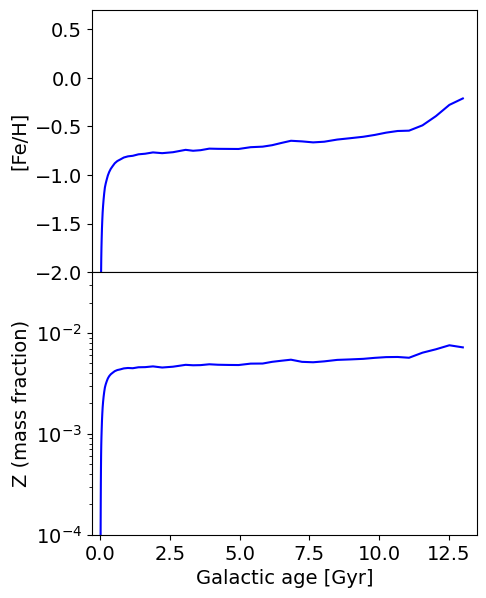

In [11]:
check_Z_evol(o_1)

# Add MRD-SNe yield

Load magneto-rotationally driven supernovae (MRD-SNe) yield from Nishimura et al. (2017), downloaded from https://github.com/nnobuya/mrsn, using the same magnetic field strength model yield as Palla et al. (2025).

In [12]:
mrd_table = repo_root / "yield_tables" / "additional_sources" / "L0.75.dat"

# Parse L0.75.dat to extract isotope names and masses (in Msun)
# File format: each line has 'name Z N A X' where X is mass fraction
# Total ejecta mass is read from the header (line 4)

# Read total ejecta mass from header
total_ejecta_msun = None
with open(mrd_table, 'r') as f:
    for line in f:
        if 'Total ejecta:' in line:
            # Extract the mass value from the header line
            parts = line.split()
            total_ejecta_msun = float(parts[3])
            break

if total_ejecta_msun is None:
    raise ValueError("Could not find 'Total ejecta:' in header of L0.75.dat")

# Parse isotope data
isotope_names = []
mrd_masses = []

with open(mrd_table, 'r') as f:
    for line in f:
        # Skip comment lines and empty lines
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        
        # Parse the data line: name Z N A X [Y]
        parts = line.split()
        if len(parts) < 5:
            continue
        
        iso_name = parts[0]
        Z = int(parts[1])
        N = int(parts[2])
        A = int(parts[3])
        X = float(parts[4])  # mass fraction
        
        # Convert isotope name to format: 'Element-A' (e.g., 'H-1', 'He-4', 'C-12')
        # Use Z and A to construct the name
        element_map = {1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N', 8: 'O',
                      9: 'F', 10: 'Ne', 11: 'Na', 12: 'Mg', 13: 'Al', 14: 'Si', 15: 'P',
                      16: 'S', 17: 'Cl', 18: 'Ar', 19: 'K', 20: 'Ca', 21: 'Sc', 22: 'Ti',
                      23: 'V', 24: 'Cr', 25: 'Mn', 26: 'Fe', 27: 'Co', 28: 'Ni', 29: 'Cu',
                      30: 'Zn', 31: 'Ga', 32: 'Ge', 33: 'As', 34: 'Se', 35: 'Br', 36: 'Kr',
                      37: 'Rb', 38: 'Sr', 39: 'Y', 40: 'Zr', 41: 'Nb', 42: 'Mo', 43: 'Tc',
                      44: 'Ru', 45: 'Rh', 46: 'Pd', 47: 'Ag', 48: 'Cd', 49: 'In', 50: 'Sn',
                      51: 'Sb', 52: 'Te', 53: 'I', 54: 'Xe', 55: 'Cs', 56: 'Ba', 57: 'La',
                      58: 'Ce', 59: 'Pr', 60: 'Nd', 61: 'Pm', 62: 'Sm', 63: 'Eu', 64: 'Gd',
                      65: 'Tb', 66: 'Dy', 67: 'Ho', 68: 'Er', 69: 'Tm', 70: 'Yb', 71: 'Lu',
                      72: 'Hf', 73: 'Ta', 74: 'W', 75: 'Re', 76: 'Os', 77: 'Ir', 78: 'Pt',
                      79: 'Au', 80: 'Hg', 81: 'Tl', 82: 'Pb', 83: 'Bi', 84: 'Po', 85: 'At',
                      86: 'Rn', 87: 'Fr', 88: 'Ra', 89: 'Ac', 90: 'Th', 91: 'Pa', 92: 'U'}
        
        element = element_map.get(Z, f'Z{Z}')
        isotope_name = f'{element}-{A}'
        
        # Convert mass fraction to mass in Msun
        mass_msun = X * total_ejecta_msun
        
        isotope_names.append(isotope_name)
        mrd_masses.append(mass_msun)

# Store as dictionary and print summary
mrd_data = dict(zip(isotope_names, mrd_masses))
print(f"Loaded {len(mrd_data)} isotopes from L0.75.dat")
print(f"Total ejecta mass: {total_ejecta_msun:.6e} Msun")

Loaded 286 isotopes from L0.75.dat
Total ejecta mass: 2.004670e-01 Msun


In [13]:
# format the table to match OMEGA's isotope naming convention
formatted_mrd_yield = []
for i in range(len(o_1.history.isotopes)):
    try: 
        get = mrd_data[o_1.history.isotopes[i]]
        formatted_mrd_yield.append(get)
    except Exception:
        formatted_mrd_yield.append(0)
formatted_mrd_yield = np.array(formatted_mrd_yield)

### 2. Prompt channel model (r-process: NSM + MRD-SNe)
Incorporate prompt r-process channel to Fornax chemical evolution model

In [14]:
# Create a modified version of o_1 by manually adding MRD yields at prompt window
# Use the same parameters as o_1 but with external_control to allow m_added parameter
o_2 = omega.omega(galaxy=galaxy, SF_law=True, sfe=sfe, mass_loading=mass_loading, \
                    nb_1a_per_m=nb_1a_per_m, transitionmass=10.0, sn1a_table=Ia_table, \
                    table = agb_table, nsmerger_table = NSM_table, external_control=True)

prompt_window = (1.0e7, 2.0e7)

count = 0

# Manually evolve o_2 by copying o_1's timesteps, adding MRD when in the prompt window
# Iterate through all valid timesteps (0 to nb_timesteps-2) to avoid out-of-bounds on ymgal access
for i_t in range(o_1.nb_timesteps - 1):
    sfr = o_1.history.sfr_abs[i_t]
    age = o_1.history.age[i_t]
    
    # Determine if we should add MRD yields
    add_mrd = (age >= prompt_window[0] and age <= prompt_window[1])
    
    # Call run_step with i_t+1 (omega uses 1-indexed steps internally)
    if add_mrd:
        # During prompt window: add MRD yields
        m_added = o_2.ymgal[i_t] + formatted_mrd_yield*5
        o_2.run_step(i_t + 1, sfr, m_added=m_added)
        count += 1*5
    else:
        # Outside prompt window: standard evolution
        o_2.run_step(i_t + 1, sfr)

# Run the final step without MRD (outside prompt window by definition at end of simulation)
# This populates the last ymgal row so plot_spectro won't return all zeros
if o_1.nb_timesteps - 1 < len(o_1.history.sfr_abs):
    o_2.run_step(o_1.nb_timesteps, o_1.history.sfr_abs[o_1.nb_timesteps - 1])

print(f"Added MRD yields in {count} timesteps within the prompt window.")

OMEGA run in progress..
..Time refinement..
Warning - Negative inflow.  The outflow rate has been increased. 17
Warning - Negative inflow.  The outflow rate has been increased. 18
Warning - Negative inflow.  The outflow rate has been increased. 19
Warning - Negative inflow.  The outflow rate has been increased. 20
   OMEGA run completed - Run time: 1.19s
Added MRD yields in 20 timesteps within the prompt window.


Quick diagnostics

In [22]:
# Get the total mass lost by stars [Msun]
m_star_lost = 0.0
for i_t in range(o_2.nb_timesteps):
    m_star_lost += np.sum(o_2.mdot[i_t])

# Stellar mass [Msun] .. corrected for stellar mass loss
print('Current stellar mass =','%.2E' %(np.sum(o_2.history.m_locked)-m_star_lost), 'Msun')

Current stellar mass = 2.83E+07 Msun


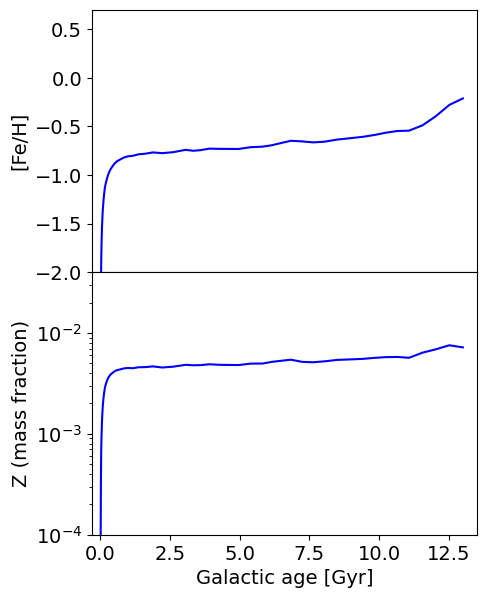

In [23]:
check_Z_evol(o_2)

1 r-process event per 1,000 CCSN or $10^5$ Msun stellar mass (Ji et al. 2016), massive classical dwarfs will experience >~ 10 r-process enrichment events over the course of their lives.
- for Fornax with ~ 20 x 10^6 Msun stellar mass, simple stellar mass scaling gives ~ 20 events

Also, try increasing the MRD-SNe yield by a factor 10.

In [15]:
# Create a modified version of o_1 by manually adding MRD yields at prompt window
# Use the same parameters as o_1 but with external_control to allow m_added parameter
o_ext = omega.omega(galaxy=galaxy, SF_law=True, sfe=sfe, mass_loading=mass_loading, \
                    nb_1a_per_m=nb_1a_per_m, transitionmass=10.0, sn1a_table=Ia_table, \
                    table = agb_table, nsmerger_table = NSM_table, external_control=True)

prompt_window = (1.0e7, 2.0e7)

count = 0

# Manually evolve o_ext by copying o_1's timesteps, adding MRD when in the prompt window
# Iterate through all valid timesteps (0 to nb_timesteps-2) to avoid out-of-bounds on ymgal access
for i_t in range(o_1.nb_timesteps - 1):
    sfr = o_1.history.sfr_abs[i_t]
    age = o_1.history.age[i_t]
    
    # Determine if we should add MRD yields
    add_mrd = (age >= prompt_window[0] and age <= prompt_window[1])
    
    # Call run_step with i_t+1 (omega uses 1-indexed steps internally)
    if add_mrd:
        # During prompt window: add MRD yields
        m_added = o_ext.ymgal[i_t] + formatted_mrd_yield*50
        o_ext.run_step(i_t + 1, sfr, m_added=m_added)
        count += 1*50
    else:
        # Outside prompt window: standard evolution
        o_ext.run_step(i_t + 1, sfr)

# Run the final step without MRD (outside prompt window by definition at end of simulation)
# This populates the last ymgal row so plot_spectro won't return all zeros
if o_1.nb_timesteps - 1 < len(o_1.history.sfr_abs):
    o_ext.run_step(o_1.nb_timesteps, o_1.history.sfr_abs[o_1.nb_timesteps - 1])

print(f"Added MRD yields in {count} timesteps within the prompt window.")

OMEGA run in progress..
..Time refinement..
Warning - Negative inflow.  The outflow rate has been increased. 17
Warning - Negative inflow.  The outflow rate has been increased. 18
Warning - Negative inflow.  The outflow rate has been increased. 19
Warning - Negative inflow.  The outflow rate has been increased. 20
   OMEGA run completed - Run time: 0.78s
Added MRD yields in 200 timesteps within the prompt window.


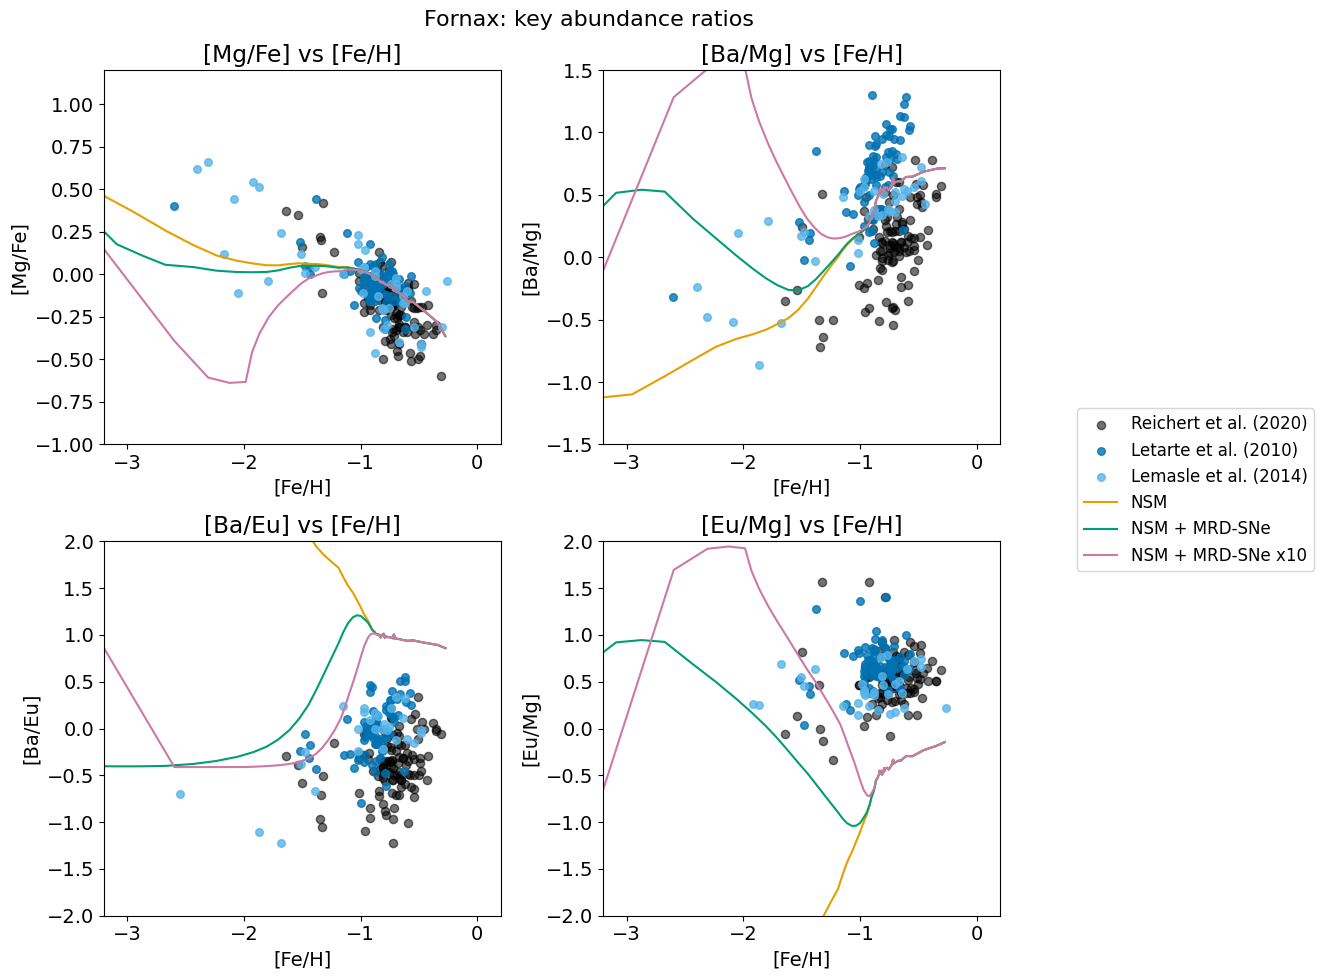

In [17]:
plot_2x2_from_cell20([(o_1, 'NSM'), (o_2, 'NSM + MRD-SNe'), (o_ext, 'NSM + MRD-SNe x10')], 
                     title='Fornax: key abundance ratios', save_fig= False)

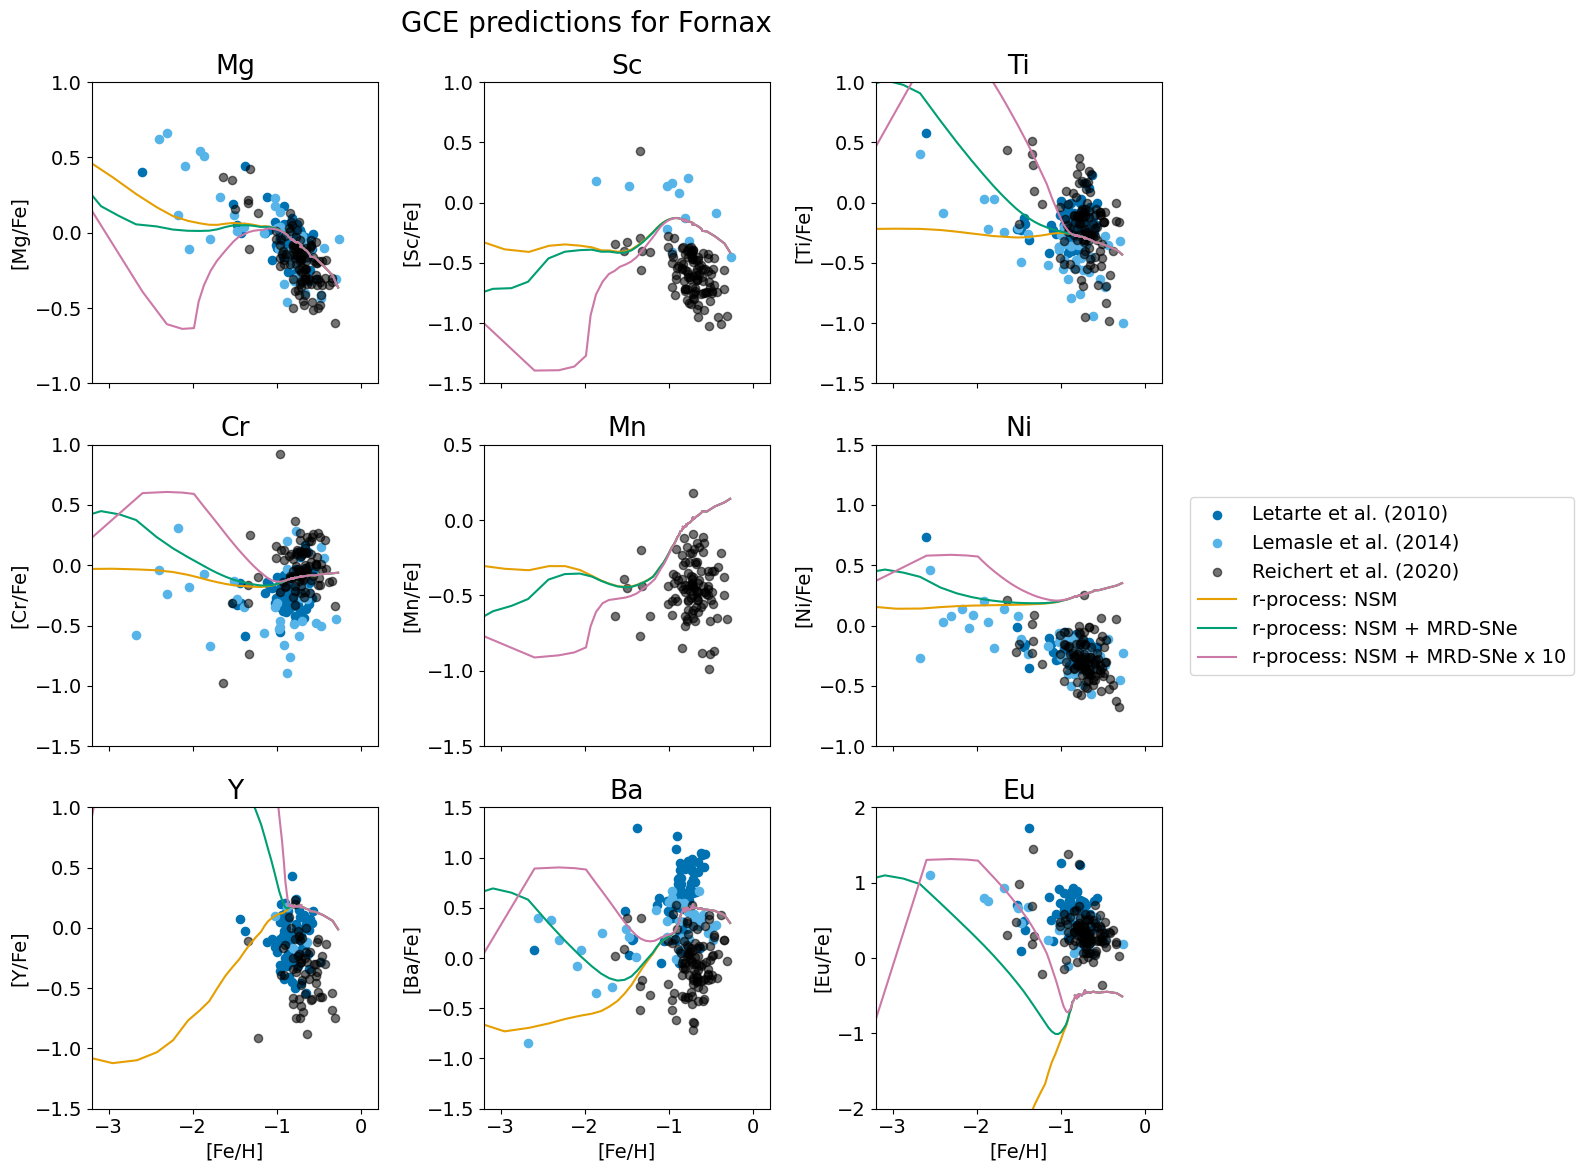

In [18]:
plot_grid([(o_1, 'r-process: NSM'),(o_2, "r-process: NSM + MRD-SNe"),(o_ext, "r-process: NSM + MRD-SNe x 10")], 
          title = "GCE predictions for Fornax", save_fig = False)

Just increasing the prompt channel yield is still not enough for Eu, the delayed channel needs increased contribution.

### 3. Model with enhanced delayed NSM Channel (o_3)

This model adds extra neutron star merger (NSM) events in a delayed channel window from 20 Myr to 8 Gyr. Extending the window upper limit yields similar results.

In [21]:
# Format NSM yields to match OMEGA's internal isotope array structure
formatted_nsm_yield = np.zeros(len(o_1.history.isotopes))

for i, iso in enumerate(o_1.history.isotopes):
    if iso in nsm_data:
        formatted_nsm_yield[i] = nsm_data[iso]

print(f"Formatted NSM yield array with {len(formatted_nsm_yield)} isotopes")
print(f"Non-zero entries: {np.count_nonzero(formatted_nsm_yield)}")

Formatted NSM yield array with 289 isotopes
Non-zero entries: 245


In [24]:
# Create o_3 model with external control
# This is based on o_1 but allows manual injection of NSM yields
o_3 = omega.omega(galaxy=galaxy, SF_law=True, sfe=sfe, mass_loading=mass_loading, \
                  nb_1a_per_m=nb_1a_per_m, transitionmass=10.0, sn1a_table=Ia_table, \
                  table=agb_table, nsmerger_table=NSM_table, external_control=True)

prompt_window = (1.0e7, 2.0e7)

# Define delayed channel window (20 Myr to 8 Gyr)
delayed_window = (2.0e7, 8.0e9)

# NSM injection interval (approximately every Myr)
nsm_interval = 1.0e6

# Track when the last NSM was added
last_nsm_age = 0.0
nsm_count = 0
mrd_count = 0

print(f"Setting up o_3 with delayed NSM channel")
print(f"Delayed window: {delayed_window[0]/1e9:.1f} - {delayed_window[1]/1e9:.1f} Gyr")
print(f"NSM injection interval: ~{nsm_interval/1e9:.1f} Gyr")

# Evolve o_3 by iterating through all timesteps
for i_t in range(o_1.nb_timesteps - 1):
    sfr = o_1.history.sfr_abs[i_t]
    age = o_1.history.age[i_t]

    # Check if we're in the delayed window and it's time to inject NSM
    in_delayed_window = (age >= delayed_window[0] and age <= delayed_window[1])
    time_for_nsm = (age - last_nsm_age) >= nsm_interval

    # Determine if we should add MRD yields
    add_mrd = (age >= prompt_window[0] and age <= prompt_window[1])

    m_added = np.zeros(len(o_1.history.isotopes))

    # Call run_step with i_t+1 (omega uses 1-indexed steps internally)
    if add_mrd:
        # During prompt window: add MRD yields
        m_added += o_3.ymgal[i_t] + formatted_mrd_yield*5
        mrd_count += 1*5
    elif in_delayed_window and time_for_nsm:
        # Add NSM yields
        m_added += o_3.ymgal[i_t] + formatted_nsm_yield
        last_nsm_age = age
        nsm_count += 1

    o_3.run_step(i_t + 1, sfr, m_added=m_added)

# Run the final step without MRD (outside prompt window by definition at end of simulation)
# This populates the last ymgal row so plot_spectro won't return all zeros
if o_1.nb_timesteps - 1 < len(o_1.history.sfr_abs):
    o_3.run_step(o_1.nb_timesteps, o_1.history.sfr_abs[o_1.nb_timesteps - 1])

print(f"\nCompleted o_3 evolution")
print(f"Total NSM events injected: {nsm_count}")
print(f"Total r-process mass added: {nsm_count * nsm_ejecta_mass:.4e} Msun")
print(f"Added MRD yields in {mrd_count} timesteps within the prompt window.")

OMEGA run in progress..
..Time refinement..
Setting up o_3 with delayed NSM channel
Delayed window: 0.0 - 8.0 Gyr
NSM injection interval: ~0.0 Gyr
Warning - Negative inflow.  The outflow rate has been increased. 17
Warning - Negative inflow.  The outflow rate has been increased. 18
Warning - Negative inflow.  The outflow rate has been increased. 19
Warning - Negative inflow.  The outflow rate has been increased. 20
Warning - Negative inflow.  The outflow rate has been increased. 21
Warning - Negative inflow.  The outflow rate has been increased. 22
Warning - Negative inflow.  The outflow rate has been increased. 23
Warning - Negative inflow.  The outflow rate has been increased. 24
Warning - Negative inflow.  The outflow rate has been increased. 25
Warning - Negative inflow.  The outflow rate has been increased. 26
Warning - Negative inflow.  The outflow rate has been increased. 27
Warning - Negative inflow.  The outflow rate has been increased. 28
Warning - Negative inflow.  The outfl

Quick diagnostics

In [26]:
# Get the total mass lost by stars [Msun]
m_star_lost = 0.0
for i_t in range(o_3.nb_timesteps):
    m_star_lost += np.sum(o_3.mdot[i_t])

# Stellar mass [Msun] .. corrected for stellar mass loss
print('Current stellar mass =','%.2E' %(np.sum(o_3.history.m_locked)-m_star_lost), 'Msun')

Current stellar mass = 2.83E+07 Msun


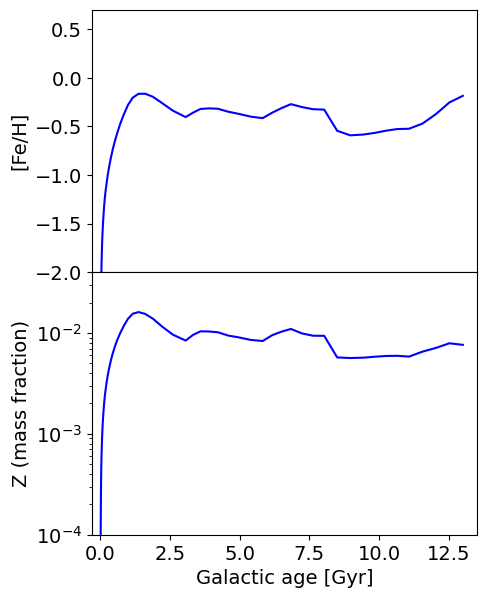

In [25]:
check_Z_evol(o_3)

#### Final plots: included in the paper
saved in /figures as pdf files

Saved: fornax_grid.pdf


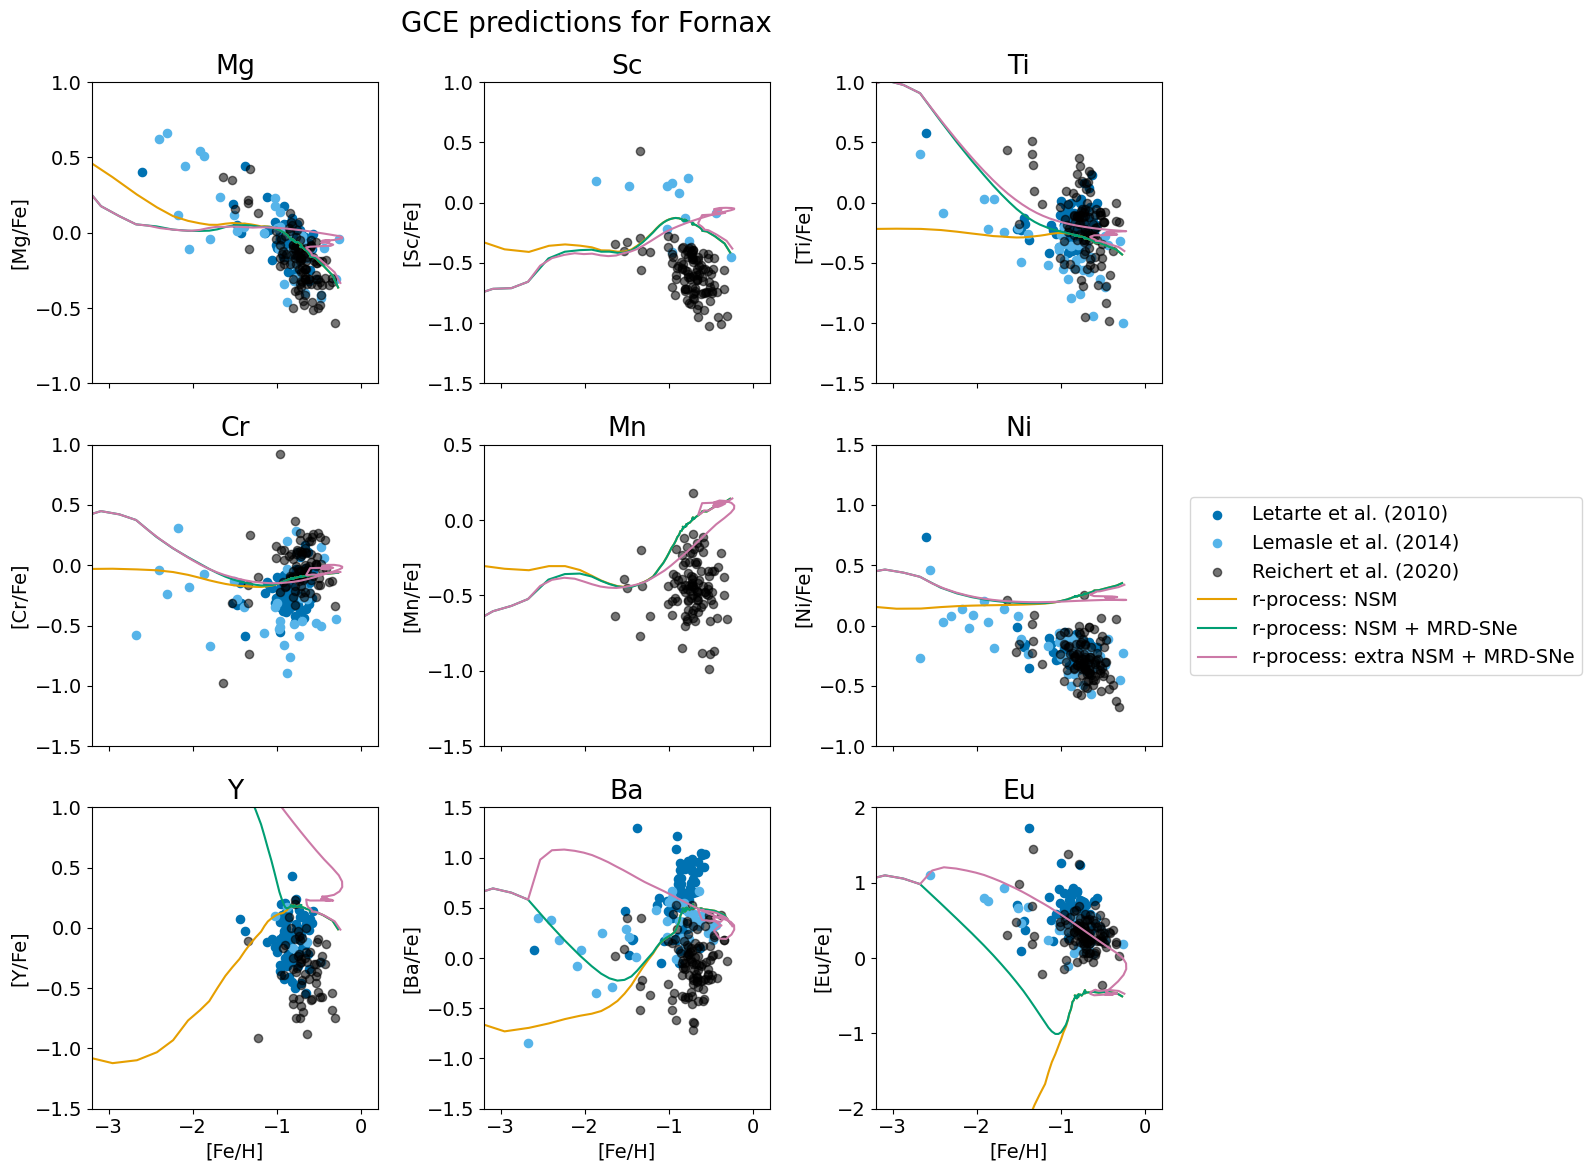

In [27]:
plot_grid([(o_1, 'r-process: NSM'),(o_2, "r-process: NSM + MRD-SNe"),(o_3, "r-process: extra NSM + MRD-SNe")], title = "GCE predictions for Fornax")

Saved: fornax_2x2.pdf


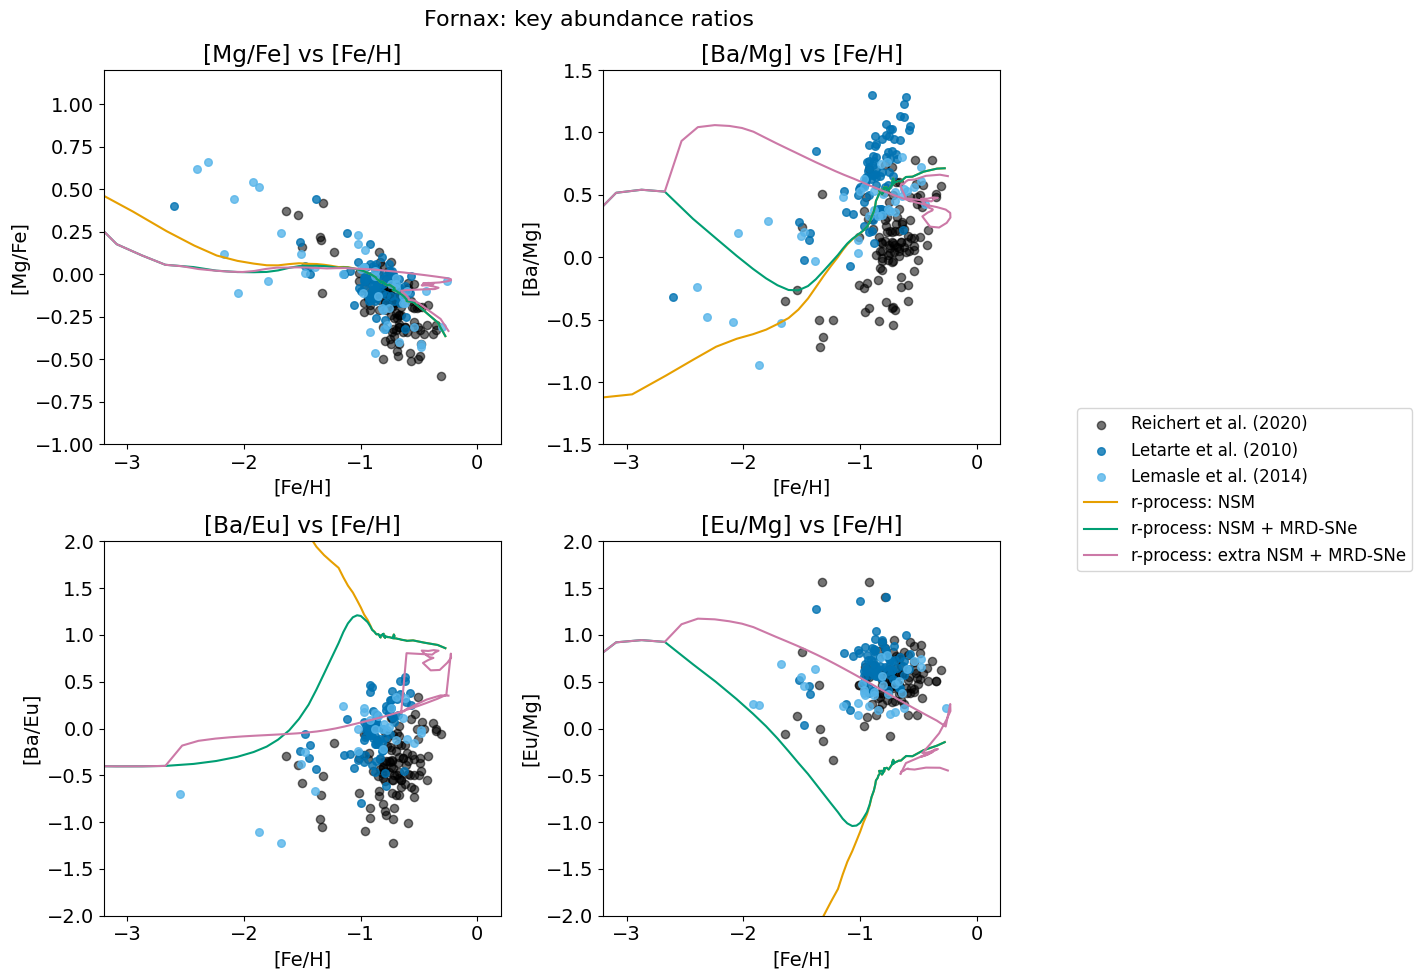

In [28]:
plot_2x2_from_cell20([(o_1, 'r-process: NSM'),(o_2, "r-process: NSM + MRD-SNe"),(o_3, "r-process: extra NSM + MRD-SNe")], title='Fornax: key abundance ratios')